# Project 3: Web APIs & NLP
---
Book 1: Data Collection<br>
Book 2: Data Cleaning & Exploratory Data Analysis<br>
**Book 3: Preprocessing & Vectorization**<br>
Book 4: ML Modeling<br>
Book 5: Sentiment Analysis, Conclusion & Recommendation<br>
Author: Lee Wan Xian

## Contents:
- [Data Preprocessing](#Data-Preprocessing)
- [Vectorization](#Vectorization)

## Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import emoji
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# this setting widens pandas column to fit 400 characters
pd.options.display.max_colwidth = 400

## Data Preprocessing

**Initial data corpus cleanup**

In [3]:
# Import raw corpus
df_raw = pd.read_csv('../data/df_raw.csv')

In [4]:
# Drop duplicates from df_raw & create a corpus copy from df_raw for modelling
df_raw.drop_duplicates(inplace=True)
df_corpus = df_raw

In [5]:
df_corpus.head()

,subreddit,title,selftext,is_video,created_utc
0,DisneyPlus,willow.... thought you were to be released today?,[removed],False,1664581822
1,DisneyPlus,Who’s excited?!,[removed],False,1664580125
2,DisneyPlus,"Hocus Pocus 2 was a let down, thoughts?",[removed],False,1664579363
3,DisneyPlus,Friend made Hocus Pocus cookies!,NaN,False,1664578323
4,DisneyPlus,Hocus Pocus 2 - Movie Discussion Thread,As there wasn't one already thought I'd create one.,False,1664575672


Export corpus for Sentiment analysis in Book 5

In [6]:
import os
# create new folder named 'data' if it does not exist
if not os.path.exists('../data'):
    os.makedirs('../data')
    
# Export the dataframes into csv files    
df_corpus.to_csv('../data/df_senti.csv', index=False)

### Feature Engineering

We will create a new feature (`full_text`) which combines word text from `title` and `selftext`.

In [7]:
# Fill the blank selftext documents with empty field
df_corpus['selftext'].fillna(value = '', inplace=True)

In [8]:
# Create full_text feature
df_corpus['full_text'] = df_corpus['title'] + ' ' + df_corpus['selftext']

Now, we can drop the unnecessary columns that would only serve as noise to the classification model training.

In [9]:
df_corpus.drop(['title', 'selftext', 'is_video', 'created_utc'],
               axis='columns',
               inplace=True)

In [10]:
df_corpus.head()

,subreddit,full_text
0,DisneyPlus,willow.... thought you were to be released today? [removed]
1,DisneyPlus,Who’s excited?! [removed]
2,DisneyPlus,"Hocus Pocus 2 was a let down, thoughts? [removed]"
3,DisneyPlus,Friend made Hocus Pocus cookies!
4,DisneyPlus,Hocus Pocus 2 - Movie Discussion Thread As there wasn't one already thought I'd create one.


### Lowercasing & Special Character Removal

In [11]:
# Function to lowercase string & remove weblinks, '\n', '&amp;', digits

def lower_remove_char(text):
    
    # Lowercase the text
    t1 = text.lower()
    
    # remove characters
    t2 = re.sub(r'http\S+', '', t1)
    t3 = t2.replace('\n', '')
    t4 = t3.replace('&amp;', '')
    t5 = re.sub(r'\d+', '', t4)
    
    return t5

In [12]:
# Remove special chars & lowercase string
df_corpus['full_text'] = df_corpus['full_text'].apply(lower_remove_char)

### Emoji conversion & Underscore removal

In [13]:
# Convert emojis into text
df_corpus['full_text'] = df_corpus['full_text'].apply(lambda x: emoji.demojize(x, delimiters=(" ", " ")))

In [14]:
# Remove underscores
df_corpus['full_text'] = df_corpus['full_text'].map(lambda x: x.replace('_', ''))

### Tokenization

In [15]:
# Instantiate tokenizer for all character words
tokenizer = RegexpTokenizer(r'\w+')

# Apply tokenizer into full_text corpus
df_corpus['token'] = df_corpus['full_text'].apply(lambda x: tokenizer.tokenize(x))

### Remove Stop Words

In [16]:
# Instantiate Stop words from nltk
nltk_stopwords = stopwords.words("english")

# Define additional stop words
add_stop_wds = ['disney','disney+','plus','series','season','episode','streaming','shows','show','episodes','app','tv','netflix','movie','movies','account','r/netflix','r/disneyplus',
                'disneyplus','removed','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# create customized stop words list
cust_stop_wds = list(set(add_stop_wds + nltk_stopwords))

In [17]:
# Function for dropping stop words from token list

def drop_stopwords_token(list_tokens):
    
    t = [token for token in list_tokens if token not in cust_stop_wds]   # Run through the list of tokens against the list of stopwords
    text = ' '.join(t)                                                   # Join them back as a string
        
    return tokenizer.tokenize(text)                                      # tokenize the string again

In [18]:
# Apply drop stop words into text_token column
df_corpus['text_token'] = df_corpus['token'].apply(drop_stopwords_token)

### Lemmatization

In [19]:
# Function to lemmatize text_tokens & return lemmatize string

def lemmatize_tokentostr(list_token):
    
    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    lem_list = []
    
    # Lemmatize all tokens in text_token
    for token in list_token:
        lem_t = lemmatizer.lemmatize(token)
        lem_list.append(lem_t)
        
    # Return lemmatize text string
    re_text = ' '.join(lem_list)
    
    return re_text

In [20]:
# Create the series for lemmatized text
df_corpus['full_text_lem'] = df_corpus['text_token'].apply(lemmatize_tokentostr)

### Stemming

In [21]:
# Function to stem text_tokens & return stemmed string

def stem_tokentostr(list_token):
    
    # Instantiate PorterStemmer
    stemmer = PorterStemmer()
    stem_list = []
    
    # stem all tokens in text_token
    for token in list_token:
        stem_t = stemmer.stem(token)
        stem_list.append(stem_t)
        
    # Return lemmatize text string
    re_text = ' '.join(stem_list)
    
    return re_text

In [22]:
# Create the series for lemmatized text
df_corpus['full_text_stem'] = df_corpus['text_token'].apply(stem_tokentostr)

In [23]:
# show the head of df_corpus
df_corpus.head()

,subreddit,full_text,token,text_token,full_text_lem,full_text_stem
0,DisneyPlus,willow.... thought you were to be released today? [removed],"[willow, thought, you, were, to, be, released, today, removed]","[willow, thought, released, today]",willow thought released today,willow thought releas today
1,DisneyPlus,who’s excited?! [removed],"[who, s, excited, removed]",[excited],excited,excit
2,DisneyPlus,"hocus pocus was a let down, thoughts? [removed]","[hocus, pocus, was, a, let, down, thoughts, removed]","[hocus, pocus, let, thoughts]",hocus pocus let thought,hocu pocu let thought
3,DisneyPlus,friend made hocus pocus cookies!,"[friend, made, hocus, pocus, cookies]","[friend, made, hocus, pocus, cookies]",friend made hocus pocus cooky,friend made hocu pocu cooki
4,DisneyPlus,hocus pocus - movie discussion thread as there wasn't one already thought i'd create one.,"[hocus, pocus, movie, discussion, thread, as, there, wasn, t, one, already, thought, i, d, create, one]","[hocus, pocus, discussion, thread, one, already, thought, create, one]",hocus pocus discussion thread one already thought create one,hocu pocu discuss thread one alreadi thought creat one


### Choosing between Lemmatized tokens and Stemming tokens

In [24]:
# Create the document-term-matrix for lemmatized full text
cvec = CountVectorizer()

lem_cvec = pd.DataFrame(data = cvec.fit_transform(df_corpus['full_text_lem']).todense(),
                        columns = cvec.get_feature_names()
                       )

In [25]:
# Show the total count of unique words in DTM (lemmatized)
print(f'Count of unique words in lemmatized text: {len(lem_cvec.columns)}')

Count of unique words in lemmatized text: 26698


In [26]:
# Create the document-term-matrix for stemmed full text
stem_cvec = pd.DataFrame(data = cvec.fit_transform(df_corpus['full_text_stem']).todense(),
                         columns = cvec.get_feature_names()
                        )

In [27]:
# Show the total count of unique words in DTM (Stemmed)
print(f'Count of unique words in stemmed text: {len(stem_cvec.columns)}')

Count of unique words in stemmed text: 21559


Even though Stemming reduced our word corpus token count by about 5000 words more than Lemmatization, it distorts the context of the original word ([source](https://towardsdatascience.com/stemming-vs-lemmatization-in-nlp-dea008600a0)). Thus, we will use lemmatized full text as the context of the word has more prediction power for this classification problem.

## Vectorization

Using Count Vectorizer - Unigram

In [28]:
print(f'The size of lemmatized document-term matrix is {lem_cvec.shape}')

The size of lemmatized document-term matrix is (29831, 26698)


In [29]:
# Show the top 25 words in DTM

full_word_count = lem_cvec.sum().sort_values(ascending=False)
lem_top_count = full_word_count[:25]

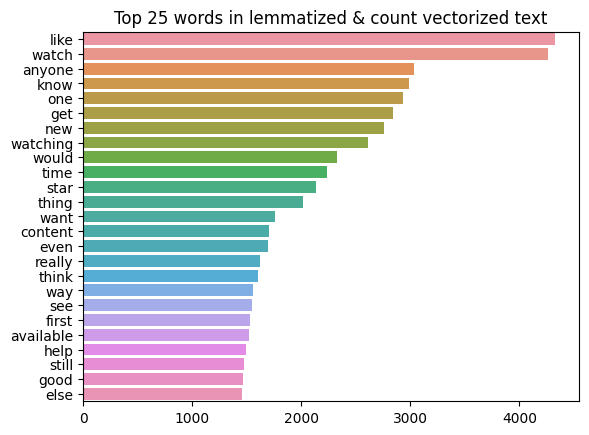

In [30]:
# Bar chart on the top 25 words in DTM

sns.barplot(x = lem_top_count.values,
            y = lem_top_count.index);

plt.title('Top 25 words in lemmatized & count vectorized text')
plt.show();

Using TF-IDF Vectorizer - Unigram

In [31]:
# TF-IDF Vectorize the document in lemmatized full text & create DTM
tfvec = TfidfVectorizer()

lem_tfvec = pd.DataFrame(data = tfvec.fit_transform(df_corpus['full_text_lem']).todense(),
                         columns = tfvec.get_feature_names()
                        )

In [32]:
print(f'The size of lemmatized document-term matrix is {lem_tfvec.shape}')

The size of lemmatized document-term matrix is (29831, 26698)


In [33]:
# Show the top 25 words in DTM

full_word_count = lem_tfvec.sum().sort_values(ascending=False)
lemtf_top_count = full_word_count[:25]

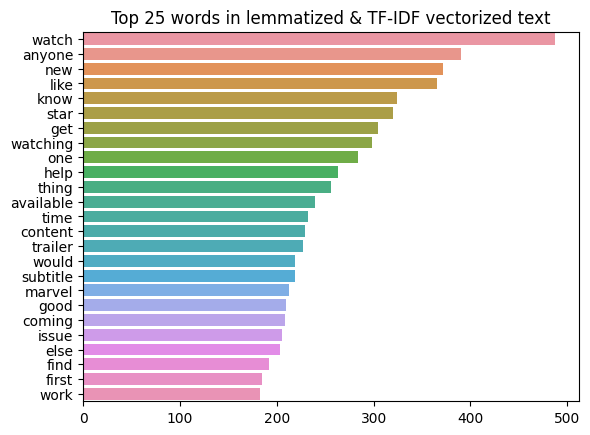

In [34]:
# Bar chart on the top 25 words in DRM

sns.barplot(x = lemtf_top_count.values,
            y = lemtf_top_count.index);

plt.title('Top 25 words in lemmatized & TF-IDF vectorized text')
plt.show();

In [35]:
print(f'List of non-english words: {tfvec.get_feature_names()[-176:]}')

List of non-english words: ['ác', 'álex', 'álvaro', 'ángel', 'ánima', 'áo', 'âge', 'ähnliche', 'änglagård', 'är', 'åmål', 'ça', 'èl', 'était', 'îs', 'ófærð', 'özge', 'özperinçci', 'último', 'úy', 'đa', 'đen', 'đi', 'điều', 'đua', 'đài', 'đè', 'đêm', 'đình', 'đôi', 'đường', 'đại', 'đảo', 'đấu', 'đầu', 'đẫm', 'đặc', 'đẹp', 'đế', 'để', 'địa', 'định', 'đồ', 'đồng', 'đổi', 'độ', 'đội', 'động', 'đời', 'ǝpᴉs', 'ǝǝs', 'ǝɥʇ', 'ɹǝɥʇo', 'αρχή', 'για', 'δείτε', 'και', 'καλή', 'λίγο', 'μονο', 'μπείτε', 'προσφορές', 'σχεδόν', 'τσάμπα', 'аbout', 'еxperiеnсе', 'оf', 'оnly', 'рassеd', 'тhere', 'ויבוא', 'זוהר', 'לפורים', 'מבית', 'עיצוב', 'שושי', 'תחפושות', 'أول', 'الأول', 'الانطلاقة', 'الرجل', 'الرمادي', 'العرض', 'الكمبيوتر', 'بجودة', 'برنامج', 'بلک', 'تحصل', 'تسجيل', 'تشويقية', 'تغيير', 'تفاصيل', 'جدید', 'رئيس', 'سر', 'سریال', 'سلسلة', 'شاشة', 'صور', 'ضرب', 'عالية', 'عرضه', 'على', 'في', 'فيديو', 'فيلم', 'قصة', 'كلمة', 'كيفية', 'لشهر', 'لـ', 'مجانا', 'مقطورة', 'من', 'موعد', 'نار', 'نظرة', 'نوفمبر', 'نيو

TF-IDF vectorization would be more favourable as it gives higher scores to word features that have more predictive power in respect to the overall corpus. In turn, it reduces noise word features. However, we will use both vectorization methods for baseline modelling later.<br>
It is good to note that the last 176 features in the word vectors are non-English words. Despite them being in a foreign language, it is fine to feed these words into the model. These foreign words would still have some predictive power.

Export corpus for ML Modelling in Book 4

In [36]:
# Create a cleaned corpus for modelling
df_corpus_clean = df_corpus[['subreddit', 'full_text', 'full_text_lem', 'full_text_stem']]

In [37]:
import os
# create new folder named 'data' if it does not exist
if not os.path.exists('../data'):
    os.makedirs('../data')
    
# Export the corpus into csv file    
df_corpus_clean.to_csv('../data/df_corpus_model.csv', index=False)

**Please proceed to Book 4 for ML Modeling**